# Homework 7 Template

Rixin Li & G . Besla

look for "****"

In [11]:
# import necessary modules
# numpy provides powerful multi-dimensional arrays to hold and manipulate data
import numpy as np
# matplotlib provides powerful functions for plotting figures
import matplotlib.pyplot as plt
# astropy provides unit system and constants for astronomical calculations
import astropy.units as u
import astropy.constants as const
# import Latex module so we can display the results with symbols
from IPython.display import Latex
%matplotlib inline

# **** import CenterOfMass to determine the COM pos/vel of M33
from CenterOfMass import CenterOfMass
from ReadFile import Read

# **** import the GalaxyMass to determine the mass of M31 for each component
from GalaxyMass1 import ComponentMass

# M33AnalyticOrbit

In [18]:
class M33AnalyticOrbit:
    """ Calculate the analytical orbit of M33 around M31 """
    
    def __init__(self,filename):
                #input: filename, name of the file

        ### get the gravitational constant (the value is 4.498502151575286e-06)
        self.G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value
        
        ### **** store the output file name
        self.file=filename
        
        ### get the current pos/vel of M33 
        # **** create an instance of the  CenterOfMass class for M33 
        M33=CenterOfMass('M33_000.txt',2)
        deltam33 = 0.1
        voldecm33 = 4
        # **** store the position VECTOR of the M33 COM (.value to get rid of units)
        M33pos = M33.COM_P(deltam33,voldecm33)
        
        M33vel = M33.COM_V(M33pos[0],M33pos[1],M33pos[2])
        
        ### get the current pos/vel of M31 
        # **** create an instance of the  CenterOfMass class for M31 \
        M31 = CenterOfMass('M31_000.txt',2)
        deltam31 = 0.1
        voldecm31 = 2

        # **** store the position VECTOR of the M31 COM (.value to get rid of units)
        M31pos = M31.COM_P(deltam31,voldecm31)
        # **** store the velocity VECTOR of the M31 COM (.value to get rid of units)
        M31vel = M31.COM_V(M31pos[0],M31pos[1],M31pos[2])
        
        ### store the DIFFERENCE between the vectors posM33 - posM31
        # **** create two VECTORs self.r0 and self.v0 and have them be the
        # relative position and velocity VECTORS of M33
        M3331posdif = np.subtract(M33pos,M31pos).value
        M3331veldif = np.subtract(M33vel,M31vel).value
        self.r0=M3331posdif
        self.v0 = M3331veldif
        
        ### get the mass of each component in M31 
        ### disk
        # **** self.rdisk = scale length (no units)
        self.rdisk = 5
        # **** self.Mdisk set with ComponentMass function. Remember to *1e12 to get the right units. Use the right ptype
        self.Mdisk = ComponentMass('M31_000.txt',2).value*1e12
        ### bulge
        # **** self.rbulge = set scale length (no units)
        self.rbulge = 1
        # **** self.Mbulge  set with ComponentMass function. Remember to *1e12 to get the right units Use the right ptype
        self.Mbulge = ComponentMass('M31_000.txt',3).value*1e12
        # Halo
        # **** self.rhalo = set scale length from HW5 (no units)
        self.rhalo = 62
        # **** self.Mhalo set with ComponentMass function. Remember to *1e12 to get the right units. Use the right ptype
        self.Mhalo = ComponentMass('M31_000.txt',1).value*1e12
    
    
    def HernquistAccel(self,M,r_a,r): # it is easiest if you take as an input the position VECTOR 
        """ **** ADD COMMENTS """
        """Input:
                M: mass of the bulge of the halo in units of Msun
                a: the scale length [kpc]
                r: vector
                
            Output:
                acceleration vector from a Hernquist profile"""
        ### **** Store the magnitude of the position vector
        rmag = np.sqrt(r[0]**2+r[1]**2+r[2]**2)
        
        ### *** Store the Acceleration
        Hern =  -self.G*M/(rmag*(r_a+rmag)**2)*r
        # NOTE: we want an acceleration VECTOR so you need to make sure that in the Hernquist equation you 
        # use  -G*M/(rmag *(ra + rmag)**2) * r --> where the last r is a VECTOR \\
        
        return Hern
    
    
    def MiyamotoNagaiAccel(self,M,rd,r):# it is easiest if you take as an input a position VECTOR  r \
        """ Input:
                M: mass of the disk for M31 [Msun]
                r = vector position of M31 (instead of using x,y,and z)
                rd = self.rdisk
            Output:
                aceleration vector for the miyamoto nagai profile"""
        zd = self.rdisk/5.0


        
        B = rd+np.sqrt(r[2]**2+zd**2)   
        R = np.sqrt(r[0]**2+r[1]**2)
        
        Zstuff = B/(np.sqrt(r[2]**2+zd**2))
        
        mna = -self.G*M/(R**2+B**2)**1.5 * r * np.array([1,1,Zstuff])
        
        return mna
        # the np.array allows for a different value for the z component of the acceleration
     
    
    def M31Accel(self,r): # input should include the position vector, r
        """ Input:
                r = position vector
            Output:
                total acceleration vector"""
                       
        ### Call the previous functions for the halo, bulge and disk
        # **** these functions will take as inputs variable we defined in the initialization of the class like 
        # self.rdisk etc. 
        
        m31bulge= self.HernquistAccel(self.Mbulge, self.rbulge, r)
        m31halo= self.HernquistAccel(self.Mhalo, self.rhalo, r)
        m31disk= self.MiyamotoNagaiAccel(self.Mdisk, self.rdisk, r)
        
        acc1= np.add(m31bulge, m31halo)
        acctot= np.add(acc1, m31disk)
            # return the SUM of the output of the acceleration functions - this will return a VECTOR 
            
        return acctot
    
    
    
    def LeapFrog(self,dt,r,v): # take as input r and v, which are VECTORS. Assume it is ONE vector at a time
        """ Input:
                dt: change in time
                r: position vector
                v: velocity vector
            Output:
                Rnew = position vector after a time dt
                Vnew = velocity vector after a time dt"""
        # predict the position at the next half timestep
        rhalf = r + v*dt/2
        
        # predict the final velocity at the next timestep using the acceleration field at the rhalf position 
        vnew = v + self.M31Accel(r)*dt
        
        # predict the final position using the average of the current velocity and the final velocity
        # this accounts for the fact that we don't know how the speed changes from the current timestep to the 
        # next, so we approximate it using the average expected speed over the time interval dt. 
        rnew = rhalf + vnew*dt/2
        
        return rnew,vnew
    
    
    
    def OrbitIntegration(self, t0, dt, tmax):
        #Input:
            # t0: starting time
            # dt: small integration time incriments
            # tmax = end time

        # initialize the time to the input starting time
        t = t0
        
        # initialize an empty array of size :  rows int(tmax/dt)+2  , columns 7
        orbit = np.zeros((int(tmax/dt)+2,7))
        
        # initialize the first row of the orbit
        orbit[0] = t0, *tuple(self.r0), *tuple(self.v0)
        # this above is equivalent to 
        # orbit[0] = t0, self.r0[0], self.r0[1], self.r0[2], self.v0[0], self.v0[1], self.v0[2]
        
        
        # initialize a counter for the orbit.  
        i = 1 # since we already set the 0th values, we start the counter at 1
        
        # start the integration (advancing in time steps and computing LeapFrog at each step)
        while (t<tmax):  # as long as t has not exceeded the maximal time 
            
            # **** advance the time by one timestep, dt
            t+=dt
            # **** store the new time in the first column of the ith row
            orbit[i][0] = t
            
            # ***** advance the position and velocity using the LeapFrog scheme
            # remember that LeapFrog returns a position vector and a velocity vector  
            # as an example, if a function returns three vectors you would call the function and store 
            # the variable like:     a,b,c = function(input)
            posnew,velnew = self.LeapFrog(dt,orbit[i-1][1:4],orbit[i-1][4:7])
         
    
            # ****  store the new position vector into the columns with indexes 1,2,3 of the ith row of orbit
            # TIP:  if you want columns 5-7 of the Nth row of an array called A, you would write : 
            # A[n, 5:8] 
            # where the syntax is row n, start at column 5 and end BEFORE column 8
            orbit[i][1:4] = posnew
            
            # ****  store the new position vector into the columns with indexes 1,2,3 of the ith row of orbit
            orbit[i][4:7] = velnew
            
            # **** update counter i , where i is keeping track of the number of rows (i.e. the number of time steps)
            i+=1
        
        
        # write the data to a file
        np.savetxt(self.file, orbit, fmt = "%11.3f"*7, comments='#', 
                   header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                   .format('t', 'x', 'y', 'z', 'vx', 'vy', 'vz'))
        
        # there is no return function

In [19]:
#save the output in a file
M33Orbit = M33AnalyticOrbit('hw7output.txt')

In [20]:
#do the integration
M33Orbit.OrbitIntegration(0,0.01,10)

In [21]:
#now we put the data into an array to be plotted
data = np.genfromtxt('hw7output.txt',dtype=None,names=True)

In [22]:
#compute the seperation of position and velocity and get the time from the array
r = np.sqrt(data['x']**2+data['y']**2+data['z']**2)
vel=np.sqrt(data['vx']**2+data['vy']**2+data['vz']**2)
t=data['t']

In [23]:
#now we are finding the difference using this code from homework 6
def relative_mag(orbit1, orbit2): 
    # Input: 3D vector 1 , 3D vector 2
    # returns the magnitude of the relative position and velocities
    pos =  np.sqrt( (orbit1['x']-orbit2['x'])**2 + (orbit1['y']-orbit2['y'])**2 + (orbit1['z']-orbit2['z'])**2)
    vel =  np.sqrt( (orbit1['vx']-orbit2['vx'])**2 + (orbit1['vy']-orbit2['vy'])**2 + (orbit1['vz']-orbit2['vz'])**2)
    return pos,vel

In [25]:
#set up data for graphing
M31orbdat = np.genfromtxt('Orbit_M31.txt',dtype=None,names=True)
M33orbdat = np.genfromtxt('Orbit_M33.txt',dtype=None,names=True)

M3331sep,M3331vel = relative_mag(M31orbdat,M33orbdat)

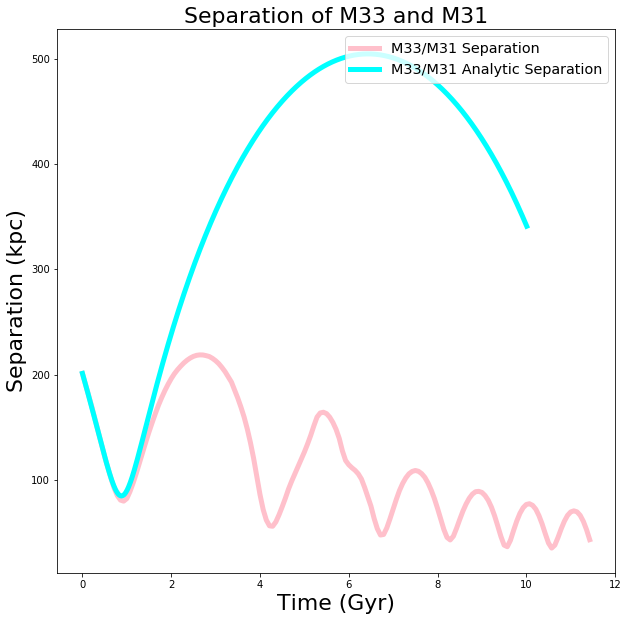

In [30]:
#plotting the difference in seperation

fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111) 

time = M31orbdat['time']/1000

# Plot the Separation vs Time 
ax.plot(time,M3331sep,color='pink', linewidth=5, label='M33/M31 Separation')
ax.plot(t,r, color='cyan', linewidth=5, label='M33/M31 Analytic Separation')

# Add labels
plt.xlabel(r'Time (Gyr)', fontsize=22)
plt.ylabel(r'Separation (kpc)', fontsize=22)
plt.title(r'Separation of M33 and M31',fontsize=22)

#legend
legend = ax.legend(loc='upper right',fontsize='x-large')

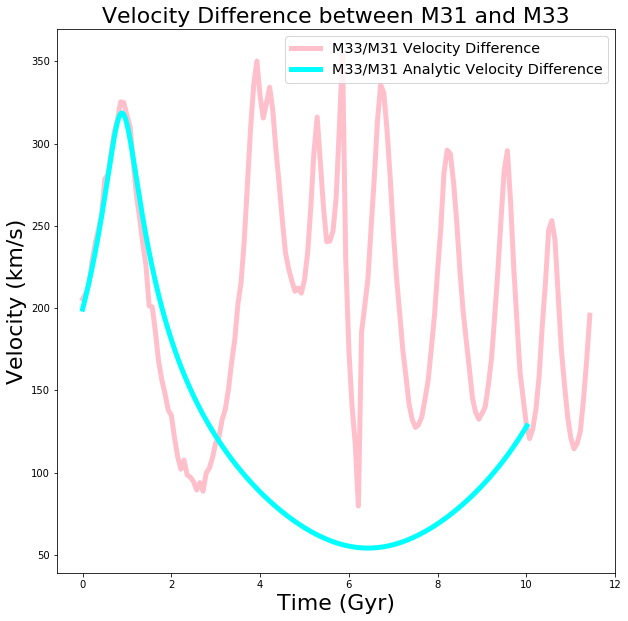

In [31]:
#now we do the same for velocity 

fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111) 

# Plot the velocity vs time
ax.plot(time,M3331vel,color='pink', linewidth=5, linestyle='-', label='M33/M31 Velocity Difference')
ax.plot(t,vel, color='cyan', linewidth=5, label='M33/M31 Analytic Velocity Difference')

# Add labels
plt.xlabel(r'Time (Gyr)', fontsize=22)
plt.ylabel(r'Velocity (km/s)', fontsize=22)
plt.title(r'Velocity Difference between M31 and M33',fontsize=22)

# legend
legend = ax.legend(loc='upper right',fontsize='x-large')

2. The plots are relatively the same until about 1-1.5 Gyr, where they quickly become very different. We see a lot more influx in the differences for the data we got in homework 6 than we did using this calculation. The data we calculated in this homework creates a smooth curve that tends to be on the extreme end, especially for the position difference, where the difference for our new data is much more than for our previous data.

3. M31 is in a gravitational tussel with the Milky Way and they will start to merge within a few Gyr. Therefore, it will play a large role in the difference between seperation of position and difference of velocity in the later years. It doesn't affect it so much now, as we can see with the alignment of the two plots in the earlier years, but it will soon play a much larger role. We are forgetting to take into account the gravitational forces that will change the dynamics between the two galaxies in the near future.

4. This would become a 3 body problem instead of a 2 body problem. We would have to include the forces of the Milky Way on the two galaxies, so we would have to calculate it in with the difference in velocity and position vectors between M31 and M33. This will change their COM in orbit which would greatly affect their position and velocity vectors, thus changing how the differences present themselves within the plots.